# Image Processing SS 20 - Assignment - 04

### Deadline is 20.5.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [ ]:
# display the plots inside the notebook
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import random
from io import BytesIO
from PIL import Image
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

In [ ]:
def average(img): 
    x,y, _ = img .shape
    avg = 0
    for i in range(x):
        for j in range(y):
            avg += (img[i,j,0]+img[i,j,1]+img[i,j,2]) / 3 
    return avg / (x*y) 

def sd_sample(img):
    x,y,_ = img.shape
    avg = average(img)
    sd = 0
    for i in range(x):
        for j in range(y):
            pixel_Value = (img[i,j,0]+img[i,j,1]+img[i,j,2])/3
            sd += pixel_Value - avg             
    return sd / ((x * y) - 1)

def sd(img):
    x,y,_ = img.shape
    avg = average(img)
    sd = 0
    for i in range(x):
        for j in range(y):
            pixel_Value = (img[i,j,0]+img[i,j,1]+img[i,j,2])/3
            sd += (pixel_Value - avg)**2             
    return sd / ((x * y))


def sdxy(img,img1):
    x,y,_ = img .shape
    avg = average(img)
    avg1 = average(img1)
    sd = 0
    for i in range(x):
        for j in range(y):
            pixel_Value = (img[i,j,0]+img[i,j,1]+img[i,j,2]) / 3
            pixel_Value1 = (img1[i,j,0]+img1[i,j,1]+img1[i,j,2]) / 3
            sd += (pixel_Value - avg) * (pixel_Value1 - avg1)             
    return sd / ((x * y) - 1)

def sampling(x,i,j):
    result = np.zeros((11,11,3))
 
    for k in range(11):
        for l in range(11):
 
            result[k,l] = x[ i + l ,j + k]
    return result


# Exercise 1 - Qualify sharpness and noise - 5 Points

Determine the noise and sharpness in the images. Plot image number vs noise

Please download sample picture from [here](http://sipi.usc.edu/database/misc.zip) and place them next to your assignment (inside the misc folder).

In [ ]:
# Load the pictures here
sample_images = []
direc = 'misc/' # directory of the sample pictures relative to your notebook
for number in [1,3,5,6]:
    sample_images.append(
        np.array(Image.open(direc+'4.2.0'+str(number)+'.tiff'))
    )
for name in ['house']:
    sample_images.append(
        np.array(Image.open(direc+name+'.tiff'))
    )


<BarContainer object of 5 artists>

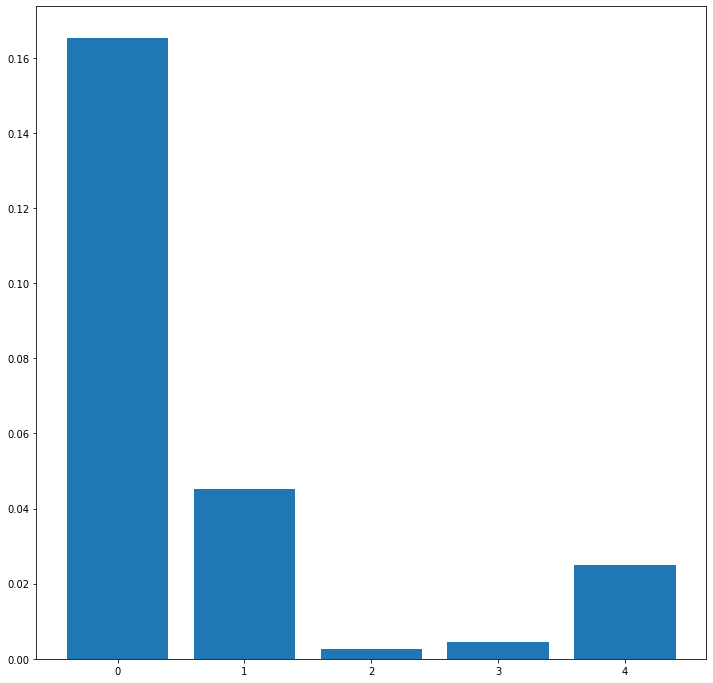

In [40]:
def average_noise(img, x, y):
    avg = 0
    for i in range(11):
        for j in range(11):
            avg += (img[x+i,y+j,0]+img[x+i,y+j,1]+img[x+i,y+j,2]) / 3 
    avg /= 121
    return avg

def sd_noise(img, x, y):
    avg = average_noise(img, x, y)
    sd = 0
    for i in range(11):
        for j in range(11):
            pixel_Value = (img[x+i,y+j,0]+img[x+i,y+j,1]+img[x+i,y+j,2])/3
            sd += (pixel_Value - avg)**2   
    sd /= 121
    return sd


k = 0
def qualify_noise(img):
    """Qualify the noise based on the std of a gaussian model.
       You may find a window that is contant in the images.
    """
    global k
    x, y = 0, 0
    if k == 0:
        x, y = 410, 340 #
    elif k == 1: 
        x, y = 420, 280 #
    elif k == 2: 
        x, y = 280, 495 #
    elif k == 3: 
        x, y = 130, 300 #
    elif k == 4: 
        x, y = 370, 240 #
    k += 1
    return sd_noise(img/255, x, y) **(0.5) #normalized value for rgb

plt.bar(range(len(sample_images)), [qualify_noise(i) for i in sample_images])


In [ ]:
def distance(x,y):
    return ( (x[0] - y[0])**2 + (x[1] - y[1])**2 + (x[2] - y[2])**2 )** 0.5


def qualify_sharpness(img):
    """Qualify the sharpness based on the average pixel differences."""
    x,y,z = img.shape
    dist = 0

 
    for i in range(x):
        for j in range(y):
            if(j + 1 == y):
                    continue
                    
            dist += distance(img[i,j],img[i,j+1])
 
    return dist / (x * y * 255) 
plt.bar(range(len(sample_images)), [qualify_sharpness(i) for i in sample_images])

Does the result match your expectations? If not what processing step can be done?

# Exercise 2 - SSIM JPEG Compression - 5 Points

In [ ]:
def jpeg_enocde(img, quality):
    pil_img = Image.fromarray(img)
    buffer = BytesIO()
    pil_img.save(buffer, "JPEG", quality=quality)
    return buffer

def jpeg_decode(buffer):
    img = Image.open(buffer)
    return np.array(img)

def jpeg_quality_filter(img, quality):
    as_jpeg = jpeg_enocde(img, quality)
    return jpeg_decode(as_jpeg)

In [ ]:
images_for_jpeg = sample_images[2::]
len(images_for_jpeg)

In [ ]:
images10 = [jpeg_quality_filter(img, 10) for img in images_for_jpeg]
images50 = [jpeg_quality_filter(img, 10) for img in images_for_jpeg]
images80 = [jpeg_quality_filter(img, 10) for img in images_for_jpeg]

In [ ]:

def ssim(img, filtered_img):
    """The SSIM similarity measure. Use the parameters from the paper 
    as on the second to last slide from the lecture

    plt.imshow(filtered_img)
    plt.show()
    """
    x,y,_ = img.shape
    result = 0 
    for i in range(x):
        for j in range(y):
            boundry_x = x - i # column 
            boundry_y = y - j # row 
            if  (boundry_x < 11):
                continue
            elif(boundry_y < 11):
                continue
            else:
                sample_img = sampling(img,i,j)
                sample_imgf= sampling(filtered_img,i,j)
                avg_img = average(sample_img)
                avg_fi  = average(sample_imgf)
                sd_img_fi = sdxy(sample_img,sample_imgf)
                sd_img = sd(sample_img)
                sd_fi = sd(sample_imgf) 
                K1 = 0.001
                L = 255
                c1 = (K1 * L) ** 2
                K2 = 0.002
                c2 = (K2 * L) ** 2
                result  += ((2*avg_img * avg_fi + c1) * (2*sd_img_fi + c2) )/ ((avg_img ** 2 + avg_fi ** 2 + c1) * (sd_img ** 2 + sd_fi ** 2 + c2))
    return (result / (x*y))


for i, img in enumerate(images_for_jpeg):
    compressed_images = [images10[i], images50[i], images80[i]]
    plt.bar(range(len(compressed_images)),
             [ssim(img, comp) for comp in compressed_images])
    plt.show()